In [249]:
import numpy as np
import matplotlib.pyplot as plt
from random import uniform
from tqdm import tqdm
from kalman_aux import *
from IPython.display import display, Math, Latex

In [2]:
class GamblersRuin:
    """
    
    """
    def __init__(self, p, k):
        """
        Init function for Gambler's Ruin simulation.
        Args:
            p (float): probability of winning a round.
            k (int): gamblers wealth.
        """
        self.p = p    # p
        self.k = k    # wealth
        self.c = 0    # counter
        
    def update_wealth(self):
        """
        
        """
        if self.k == 0:
            return 0
        else:
            self.c += 1
            self.k += 2*int(uniform(0,1) < self.p) - 1
        return self.k

100%|██████████| 50/50 [00:08<00:00,  5.97it/s]


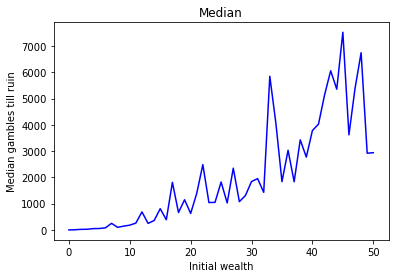

In [3]:
n_execs = 20
limit = 51
p = 0.5
times = np.zeros((limit,n_execs))
for k in tqdm(range(1,limit)):
    for ex in range(n_execs):
        gr = GamblersRuin(p, k+1)
        while gr.update_wealth() and gr.c < 1e5: ## tope
            #print(gr.k)
            pass
        times[k][ex] = gr.c

plt.xlabel(f'Initial wealth')
plt.ylabel(f'Median gambles till ruin')
plt.title(f'Median')
plt.plot(np.arange(limit), np.median(times, axis=1), color="b")

In [9]:
times

array([[0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [6.3200e+02, 2.0000e+01, 2.0000e+00, ..., 5.0200e+02, 4.0000e+00,
        2.0000e+00],
       [7.0000e+00, 6.3000e+01, 5.1000e+01, ..., 9.0000e+00, 1.9610e+03,
        7.0000e+00],
       ...,
       [2.9550e+03, 1.4190e+03, 3.1090e+03, ..., 4.4490e+03, 5.4910e+03,
        4.0359e+04],
       [1.0560e+03, 2.3712e+04, 3.9800e+03, ..., 1.3286e+04, 4.1020e+03,
        1.1500e+03],
       [7.6197e+04, 1.0000e+05, 1.0065e+04, ..., 4.9899e+04, 4.5300e+02,
        5.3499e+04]])

Text(0.5, 0.98, 'Mean and variance analysis')

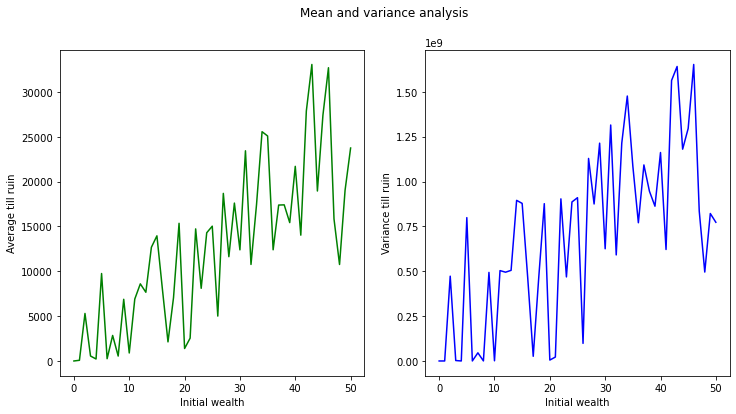

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].set_xlabel(f'Initial wealth')
ax[1].set_xlabel(f'Initial wealth')
ax[0].set_ylabel(f'Average till ruin')
ax[1].set_ylabel(f'Variance till ruin')
ax[0].plot(np.arange(limit), np.mean(times, axis=1), color="g")
ax[1].plot(np.arange(limit), np.var(times, axis=1), color="b")
fig.suptitle("Mean and variance analysis")

In [283]:
class KalmanFilter:
    
    def __init__(self, A, B, C, Q, R, n, times):
        """
        Init function for Kalman Filter
        """
        self.A = A                                                                                      # A, hidden process for state matrix
        self.B = B                                                                                      # B, hidden process for state matrix
        self.C = C                                                                                      # C, observable process for state matrix

        self.Q = Q                                                                                      # Q, covariance matrix related to w_t (defined in kalman_aux.py)
        self.R = R                                                                                      # R, covariance matrix related to v_t (defined in kalman_aux.py)

        self.times = times                                                                              # save times for simulation
        self.P = np.diag(np.full(self.A.shape[0], sigma_w))                                             # P, process covariance matrix initial estimation
        
        self.z_t = np.zeros((2,))                                                                       # init observation process
        self.x_t = np.zeros((4,))                                                                       # uniform initial
        
        self.u_t = np.array([u_f(i) for i in range(times)])                                             # input function
        
        self.w_t = np.random.normal(mu, sigma, (100, 4))                                                # gaussian noise R^2
        self.v_t = np.random.normal(mu, sigma, (100, 2))                                                # gaussian noise R^4
        
        self.n = n                                                                                      # number of experiments
        self.e_t = np.zeros((times, n))                                                                 # init relative error
        self.K_t = np.zeros((A.shape[0], C.shape[0]))                                                   # init K Gain

    def kf_system(self, t):
        """
        Computes dynamic system defined by
            x_{t+1} = Ax_t + w_t
                z_t = Cx_t + v_t
        """
        self.z_t = self.C @ self.x_t + self.v_t[t]                                                      # update observation process
        self.x_t = self.A @ self.x_t + self.B * self.u_t[t] + self.w_t[t]                               # update states

    def kf_gain(self, P_bar):
        """
        Computes the Kalman Gain given by
            K_t(C \bar P_t C' + R) = \bar P_t C'
        """
        self.K_t = P_bar @ self.C.T @ np.linalg.inv(self.C @ P_bar @ self.C.T + self.R)                 # update kalman gain

    def kf_update_matrix(self, x_bar, P_bar):
        """
        Updates the estimate and the covariance
        """
        x_hat = self.x_t + self.K_t @ (self.z_t - self.C @ self.x_t)                                    # update the estimate
        P_t = np.identity(self.C.shape[1]) - self.K_t @ self.C                                          # update the covariance

        return x_hat, P_t

    def kf_compute_priors(self, x_hat, P_t, t):
        """
        Computes the priors (predict)
        """
        x_bar = self.A @ x_hat + self.B * self.u_t[t]                                                   # compute the priors (state matrix)
        P_bar = self.A @ P_t @ self.A.T + self.Q                                                        # compute the priors (process covariance matrix)

        return x_bar, P_bar

    def kf_relative_error(self, x_hat, i, t):
        """
        Computes relative error
        """    
        self.e_t[t, i] = (np.linalg.norm(x_hat - self.x_t) ** 2) / (np.linalg.norm(self.x_t) ** 2)      # accumulate relative error
            
    def kf_run(self):
        """
        KF simulation
        """
        # initial values
        x_bar = self.x_t
        P_bar = self.P
        #x_pred = np.zeros((self.n, self.times, A.shape[0]))

        # n experiments
        for i in range(self.n):
            # simulation times = 0,...,99
            for t in range(self.times):
                self.kf_system(t)
                self.kf_gain(P_bar)
                x_hat, P_t = self.kf_update_matrix(x_bar, P_bar)
                x_bar, P_bar = self.kf_compute_priors(x_hat, P_t, t)
                self.kf_relative_error(x_hat, i, t)
                #x_pred[i, t] = x_hat
                #print('x_hat ..... ', x_hat)

        #print('aaa --- ', x_pred.shape)
        #print('bbb ---', np.mean(x_pred, axis=0).shape)
        #print('ccc ---', self.e_t.shape)
        mean_err = np.mean(self.e_t, axis=1)
        std_err = np.std(err_kf, axis=1) / self.n   
        
        return self.e_t, mean_err, std_err

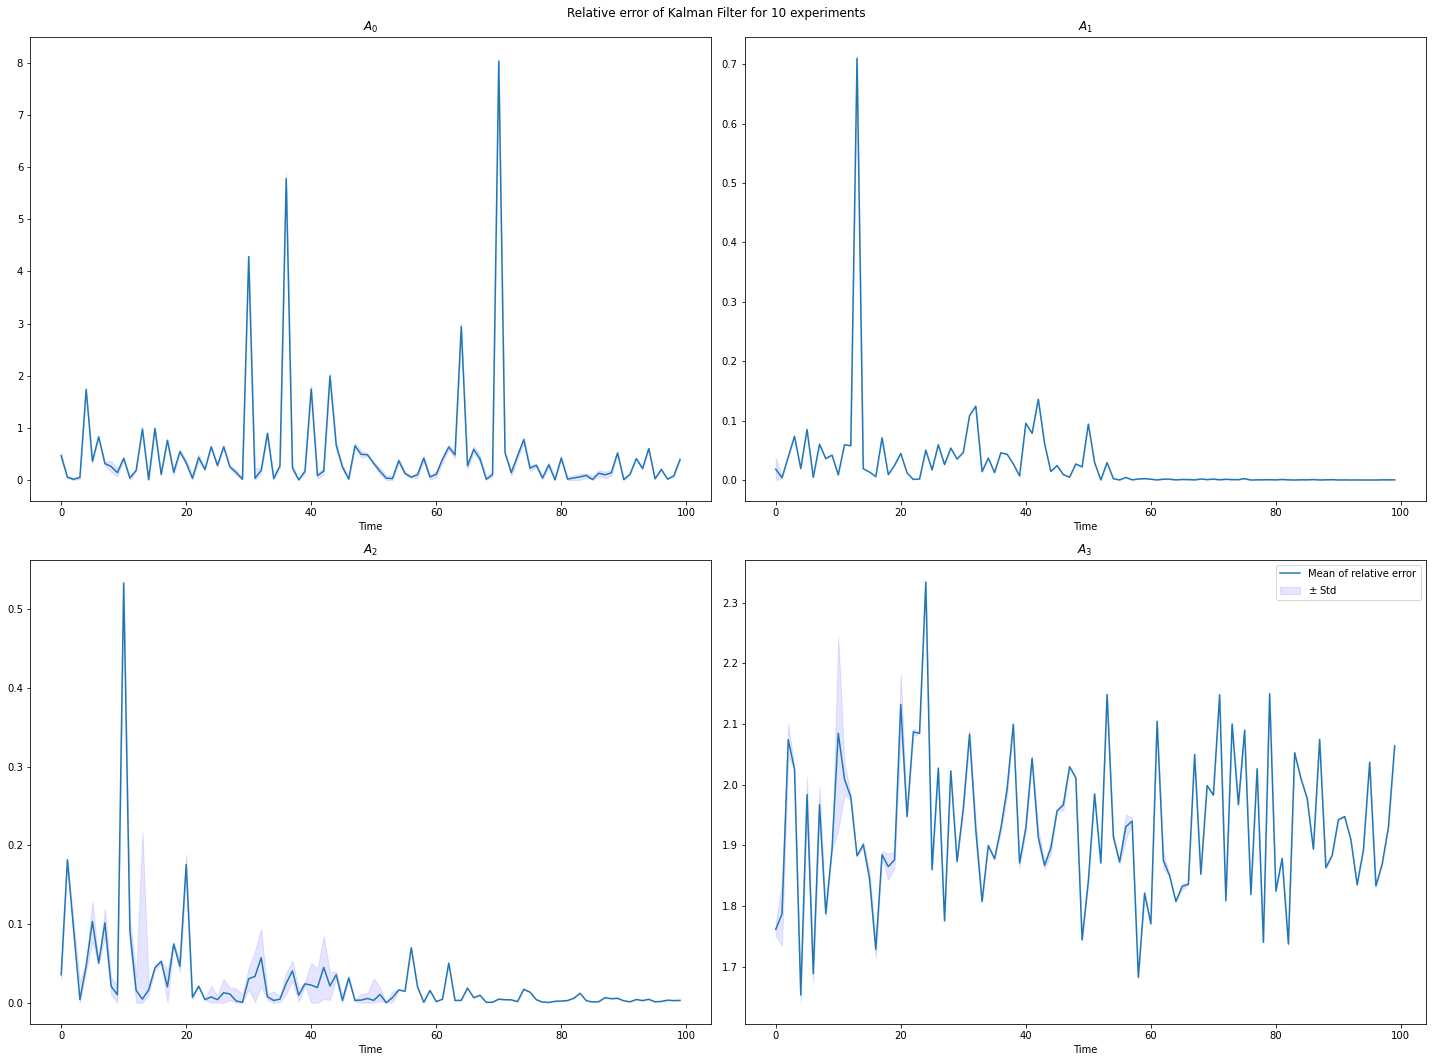

In [338]:
a_1 = [0.2, 0.1, 0., -0.1]
a_2 = [0.99, 0.1, 0., -0.1]
a_3 = [1., 0.1, 0., -0.1]
a_4 = [0.2, 0.1, 0., -1.]
a_values = [a_1, a_2, a_3, a_4]

B = np.ones(4).T
C = np.array([[1., 0., 0., 0.],
              [0., 1., 0., 0.]])

n = 10
times = 100
mu, sigma = 0., 1.

KF_outputs = []
errors, stds = [], []
for i, matrix in enumerate(a_values):
    A = np.array(mk_mat(matrix))
    KF = KalmanFilter(A, B, C, Q, R, n, times)
    err_kf, mean_err, std_err = KF.kf_run()
    KF_outputs.append(KF)
    errors.append(mean_err)
    stds.append(std_err)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,15))
fig.suptitle(f'Relative error of Kalman Filter for {n} experiments')

ax1.plot(np.arange(times), errors[0], label=f"Mean of relative error")
ax1.fill_between(np.arange(times), np.maximum(errors[0] - stds[0], 0),
                 errors[0] + stds[0],
                 color = 'b', alpha = 0.1,
                 label = r"$\pm$ Std")
ax1.set_title(f'$A_{0}$')
ax1.set_xlabel("Time")

ax2.plot(np.arange(times), errors[1], label=f"Mean of relative error")
ax2.fill_between(np.arange(times), np.maximum(errors[1] - stds[1], 0),
                 errors[1] + stds[1],
                 color = 'b', alpha = 0.1,
                 label = r"$\pm$ Std")
ax2.set_title(f'$A_{1}$')
ax2.set_xlabel("Time")

ax3.plot(np.arange(times), errors[2], label=f"Mean of relative error")
ax3.fill_between(np.arange(times), np.maximum(errors[2] - stds[2], 0),
                 errors[2] + stds[2],
                 color = 'b', alpha = 0.1,
                 label = r"$\pm$ Std")
ax3.set_title(f'$A_{2}$')
ax3.set_xlabel("Time")

ax4.plot(np.arange(times), errors[3], label=f"Mean of relative error")
ax4.fill_between(np.arange(times), np.maximum(errors[3] - stds[3], 0),
                 errors[3] + stds[3],
                 color = 'b', alpha = 0.1,
                 label = r"$\pm$ Std")
ax4.set_title(f'$A_{3}$')
ax4.set_xlabel("Time")

fig.tight_layout()
plt.legend()
plt.show()